In [ ]:
!pip install bayesian-optimization

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import PowerTransformer
import re

In [ ]:
batsman = pd.read_csv('batsman_level_scorecard.csv')
bowler = pd.read_csv('bowler_level_scorecard.csv')
train = pd.read_csv('train_data.csv')
# test = pd.read_csv('test_data.csv')
test = pd.read_csv('data_with_samplefeatures.csv')
matches = pd.read_csv('match_level_scorecard.csv')

In [ ]:
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

In [ ]:
train['winner_01'] = train.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [ ]:
def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.

    Parameters-
    1. X_12: dataset to build the RnP on.
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.

    Output-
    1. Rank and Plot

    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(20,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

In [ ]:
train['toss_winner_01'] = np.where(train['toss winner']==train['team2'], 1, 0)
test['toss_winner_01'] = np.where(test['toss winner']==test['team2'], 1, 0)

In [ ]:
## Toss decision - categorical - 1 if winner bats, 0 otherwise

train['toss_decision_01'] = np.where(train['toss decision']=='bat', 1, 0)
test['toss_decision_01'] = np.where(test['toss decision']=='bat', 1, 0)

In [ ]:
LabelEncoder = LabelEncoder()

In [ ]:
train['season_enc'] = LabelEncoder.fit_transform(train['season'])
test['season_enc'] = LabelEncoder.fit_transform(test['season'])


In [ ]:
lighting_one_hot = pd.get_dummies(train['lighting'], prefix='lighting').astype(int)

# Concatenate the one-hot encoded columns back to the original DataFrame
train = pd.concat([train, lighting_one_hot], axis=1)

In [ ]:
lighting_one_hot = pd.get_dummies(test['lighting'], prefix='lighting').astype(int)

# Concatenate the one-hot encoded columns back to the original DataFrame
test = pd.concat([test, lighting_one_hot], axis=1)

In [ ]:
matches['team1_bat_inning'] = np.where( ((matches['team1']==matches['toss winner'])&(matches['toss decision']=='bat'))|\
                                               ((matches['team2']==matches['toss winner'])&(matches['toss decision']=='field')) , 1, 2)

In [ ]:
matches['inning1_bat_id'] = np.where(matches['team1_bat_inning']==1,matches['team1_id'],matches['team2_id'])

In [ ]:
batsman = batsman.merge(matches[['match id', 'team1_id', 'team2_id',"team1_bat_inning"]], on='match id', how='left')

In [ ]:
def assign_team_id(row):
    if row['inning'] == row["team1_bat_inning"]:
        return row['team1_id']
    else:
        return row['team2_id']

In [ ]:
batsman['team_id'] = batsman.apply(assign_team_id, axis=1)

In [ ]:
batsman.drop(["team1_id","team2_id","team1_bat_inning"],axis=1,inplace=True)

In [ ]:
batsman['Fours'].fillna(0 , inplace = True)
batsman['Sixes'].fillna(0 , inplace = True)
batsman.isna().sum()

match id              0    
batsman               0    
batsman_id            0    
batsman_details       0    
is_batsman_captain    0    
is_batsman_keeper     0    
inning                0    
runs                  0    
balls_faced           0    
over_faced_first      0    
wicket kind           6211 
out_by_bowler         6211 
out_by_fielder        12431
bowler_id             7326 
bowler_details        7326 
is_bowler_keeper      6668 
is_bowler_captain     7326 
strike_rate           12   
Fours                 0    
Sixes                 0    
match_dt              0    
team_id               0    
dtype: int64

In [ ]:
bowler = bowler.merge(matches[['match id', 'team1_id', 'team2_id',"team1_bat_inning"]], on='match id', how='left')

In [ ]:
def assign_team_id_2(row):
    if row['inning'] == row["team1_bat_inning"]:
        return row['team2_id']
    else:
        return row['team1_id']

In [ ]:
bowler['team_id'] = bowler.apply(assign_team_id_2, axis=1)

In [ ]:
bowler.drop(["team1_id","team2_id","team1_bat_inning"],axis=1,inplace=True)

In [ ]:
trainCopy = train.copy()

In [ ]:
def calculate_head_to_head_win_percentage(team1_id, team2_id, match_date, matches_data, N=15):

    head_to_head_matches = matches_data[((matches_data['team1_id'] == team1_id) & (matches_data['team2_id'] == team2_id)) |
                                        ((matches_data['team1_id'] == team2_id) & (matches_data['team2_id'] == team1_id))]


    head_to_head_matches = head_to_head_matches[head_to_head_matches['match_dt'] < match_date]


    head_to_head_matches = head_to_head_matches.sort_values(by='match_dt').tail(N)

    if head_to_head_matches.empty:
        return 0.5

    team1_wins = head_to_head_matches[(head_to_head_matches['winner_id'] == team1_id)].shape[0]
    total_matches = head_to_head_matches.shape[0]

    win_percentage = team1_wins / total_matches if total_matches > 0 else 0.5

    return win_percentage

# train['team1_winp_team2_last15'] = train.apply(lambda row: calculate_head_to_head_win_percentage(row['team1_id'], row['team2_id'], row['match_dt'], matches), axis=1)
# test['team1_winp_team2_last15'] = test.apply(lambda row: calculate_head_to_head_win_percentage(row['team1_id'], row['team2_id'], row['match_dt'], matches), axis=1)


In [ ]:
batsman_grp = batsman[["Fours","match id","Sixes","balls_faced","runs","team_id"]].groupby(["match id","team_id"]).sum()

In [ ]:
batsman_grp

Fours  Sixes  balls_faced  runs
match id team_id                                 
8587795  33914    13.0   8.0    120          169 
         33942    15.0   5.0    119          160 
8587802  33928    19.0   6.0    120          183 
         33956    13.0   7.0    122          170 
8587816  33935    18.0   6.0    121          177 
...                ...   ...    ...          ... 
9997105  216      12.0   7.0    115          153 
10033547 34       13.0   6.0    119          142 
         41       9.0    10.0   120          156 
10033554 34       11.0   9.0    123          167 
         41       13.0   14.0   120          199 

[3884 rows x 4 columns]

In [ ]:
def RosterData(roster , matchesId):
    rosterIds = list(map(float, roster.split(':')))

    batsmanData = batsman[(batsman['match id'].isin(matchesId)) & (batsman['batsman_id'].isin(rosterIds))]
    bowlerData = bowler[(bowler['match id'].isin(matchesId)) & (bowler['bowler_id'].isin(rosterIds))]

    return batsmanData , bowlerData

In [ ]:
def calculate_batting_strike_rate(team_id, match_date, batsman_data, match_data, window=5):
    alpha = 1
    last_n_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
    last_n_matches = last_n_matches[last_n_matches['match_dt'] < match_date].sort_values(by='match_dt').tail(window)
    last_n_match_ids = last_n_matches['match id'].tolist()

    if not last_n_match_ids:
        return alpha

    team_batsman_data = batsman_data[(batsman_data['match id'].isin(last_n_match_ids)) & (batsman_data['team_id'] == team_id)]

    total_runs = team_batsman_data['runs'].sum()
    total_balls = team_batsman_data['balls_faced'].sum()

    return (total_runs / total_balls) * 100 + alpha if total_balls > 0 else alpha

# Apply the function to create the new features for team1 and team2
train['team1_batting_strike_rate'] = train.apply(lambda row: calculate_batting_strike_rate(row['team1_id'], row['match_dt'], batsman, matches), axis=1)
train['team2_batting_strike_rate'] = train.apply(lambda row: calculate_batting_strike_rate(row['team2_id'], row['match_dt'], batsman, matches), axis=1)

test['team1_batting_strike_rate'] = test.apply(lambda row: calculate_batting_strike_rate(row['team1_id'], row['match_dt'], batsman, matches), axis=1)
test['team2_batting_strike_rate'] = test.apply(lambda row: calculate_batting_strike_rate(row['team2_id'], row['match_dt'], batsman, matches), axis=1)

train['team1_batting_strike_rate'].fillna(0, inplace=True)
train['team2_batting_strike_rate'].fillna(0, inplace=True)
test['team1_batting_strike_rate'].fillna(0, inplace=True)
test['team2_batting_strike_rate'].fillna(0, inplace=True)

train['Strike Rate Index'] = 1/(1 + np.exp(-train['team1_batting_strike_rate'] / train['team2_batting_strike_rate']))
test['Strike Rate Index'] = 1/(1 + np.exp(-test['team1_batting_strike_rate'] / test['team2_batting_strike_rate']))

train.drop("team1_batting_strike_rate",inplace=True,axis=1)
train.drop('team2_batting_strike_rate',inplace=True,axis=1)
test.drop("team1_batting_strike_rate",inplace=True,axis=1)
test.drop('team2_batting_strike_rate',inplace=True,axis=1)



slope: 0.57 / 0.42 =  1.34


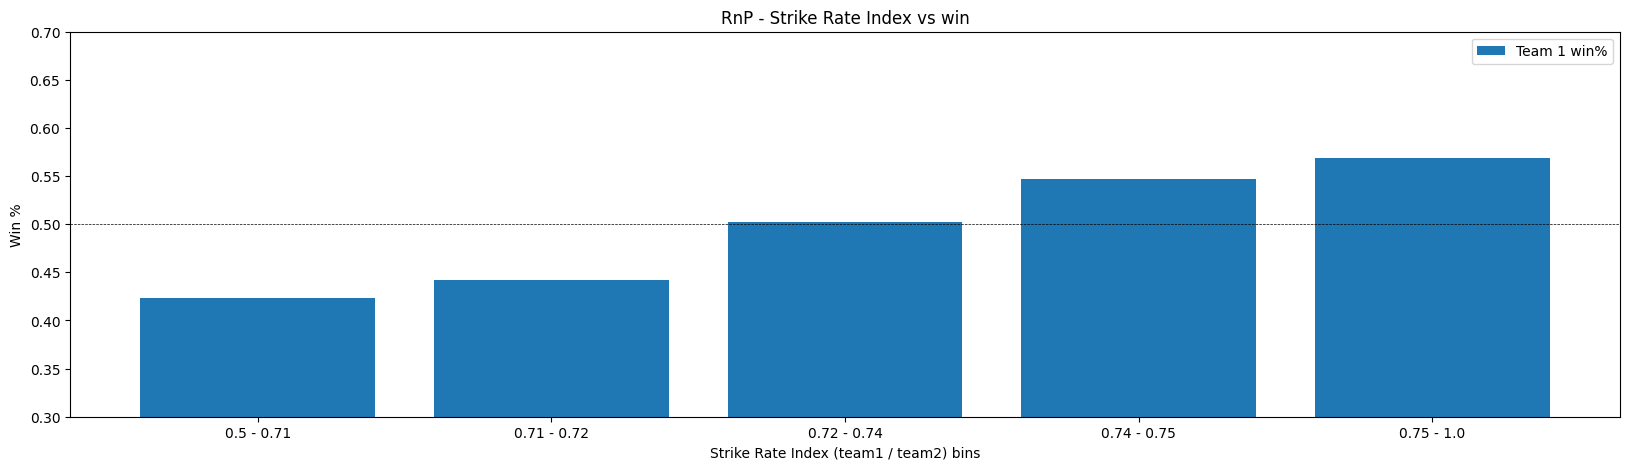

In [ ]:
createRnP(train,'Strike Rate Index')

In [ ]:
def BigInningIndex(team_id, match_date, n=10):
  alpha = 1
  matchesData = matches[(matches['match_dt'] < match_date) & ((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id))]\
                                    .sort_values(by='match_dt').tail(n)

  if matchesData.empty:
      return alpha


  BatsmanData = batsman[(batsman['match id'].isin(matchesData['match id'].tolist())) & (batsman['team_id'] == team_id)]
  totalBigInning = BatsmanData[(BatsmanData['runs'] >= 50)]  +  BatsmanData[(BatsmanData['runs'] >= 100)]
  totalBigInning = totalBigInning.shape[0]

  return totalBigInning / len(matchesData) + alpha

train['team1_big'] = train.progress_apply(lambda x: \
                                  BigInningIndex(x['team1_id'], x['match_dt'], 10), axis=1)
train['team2_big'] = train.progress_apply(lambda x: \
                                  BigInningIndex(x['team2_id'], x['match_dt'], 10), axis=1)
test['team1_big'] = test.progress_apply(lambda x: \
                                  BigInningIndex(x['team1_id'], x['match_dt'], 10), axis=1)
test['team2_big'] = test.progress_apply(lambda x: \
                                  BigInningIndex(x['team2_id'], x['match_dt'], 10), axis=1)

train['team1_big'].fillna(0 , inplace = True)
train['team2_big'].fillna(0 , inplace = True)
test['team1_big'].fillna(0 , inplace = True)
test['team2_big'].fillna(0 , inplace = True)

train['Big Inning Index'] = train['team1_big'] / train['team2_big']
test['Big Inning Index'] = test['team1_big'] / test['team2_big']

train.drop("team1_big",inplace=True,axis=1)
train.drop('team2_big',inplace=True,axis=1)
test.drop("team1_big",inplace=True,axis=1)
test.drop('team2_big',inplace=True,axis=1)

100%|██████████| 207/207 [00:01<00:00, 126.69it/s]


In [ ]:
train['Big Inning Index'].mean()

1.0231190000464656

slope: 0.57 / 0.44 =  1.31


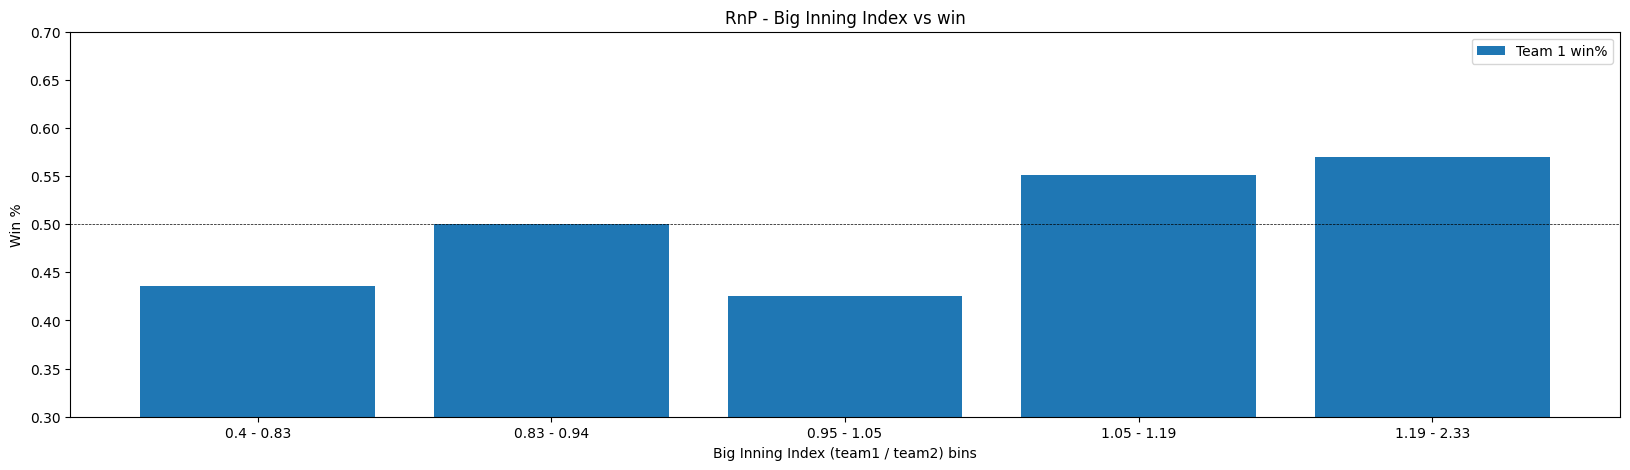

In [ ]:
createRnP(train,'Big Inning Index')

In [ ]:
def FinishingIndex(team_id, match_date, n=10):
  alpha = 1
  matchesData = matches[(matches['match_dt'] < match_date) & ((matches['team1_id'] == team_id) | (matches['team2_id']==team_id))]\
                                    .sort_values(by='match_dt').tail(n)

  if matchesData.empty:
      return alpha

  remainingWicket =  (10 - matchesData[matchesData['inning1_bat_id'] == team_id]['inning1_wickets']).sum() +\
                    (10 - matchesData[matchesData['inning1_bat_id'] != team_id]['inning2_wickets']).sum()

  return remainingWicket / len(matchesData) + alpha

train['team1_finishing'] = train.progress_apply(lambda x: \
                                  FinishingIndex(x['team1_id'], x['match_dt'], 10), axis=1)
train['team2_finishing'] = train.progress_apply(lambda x: \
                                  FinishingIndex(x['team2_id'], x['match_dt'], 10), axis=1)
test['team1_finishing'] = test.progress_apply(lambda x: \
                                  FinishingIndex(x['team1_id'], x['match_dt'], 10), axis=1)
test['team2_finishing'] = test.progress_apply(lambda x: \
                                  FinishingIndex(x['team2_id'], x['match_dt'], 10), axis=1)

train['team1_finishing'].fillna(0 , inplace = True)
train['team2_finishing'].fillna(0 , inplace = True)
test['team1_finishing'].fillna(0 , inplace = True)
test['team2_finishing'].fillna(0 , inplace = True)

train['Finishing Index'] = 1/(1 + np.exp(-train['team1_finishing'] / train['team2_finishing']))
test['Finishing Index'] = 1/(1 + np.exp(-test['team1_finishing'] / test['team2_finishing']))

train.drop("team1_finishing",inplace=True,axis=1)
train.drop('team2_finishing',inplace=True,axis=1)
test.drop("team1_finishing",inplace=True,axis=1)
test.drop('team2_finishing',inplace=True,axis=1)


100%|██████████| 207/207 [00:00<00:00, 307.60it/s]


slope: 0.54 / 0.46 =  1.17


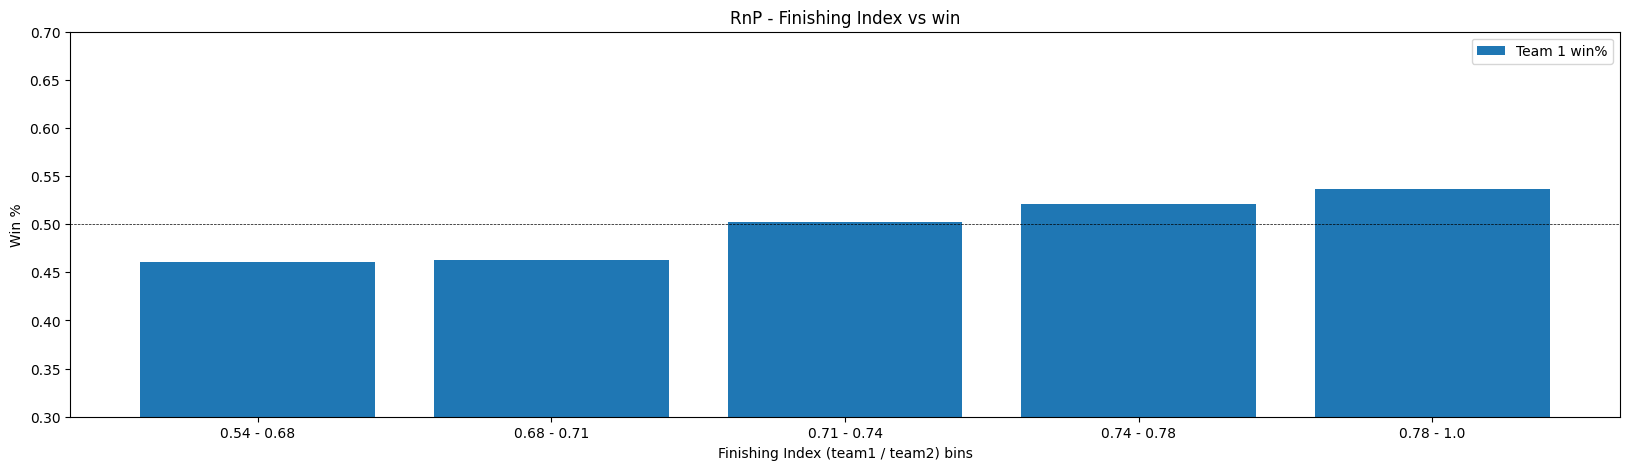

In [ ]:
createRnP(train,'Finishing Index')

In [ ]:

train.drop('ground_avg_runs_last15',inplace=True,axis=1)
train.drop('team1_winp_team2_last15',inplace=True,axis=1)

slope: 0.58 / 0.4 =  1.47


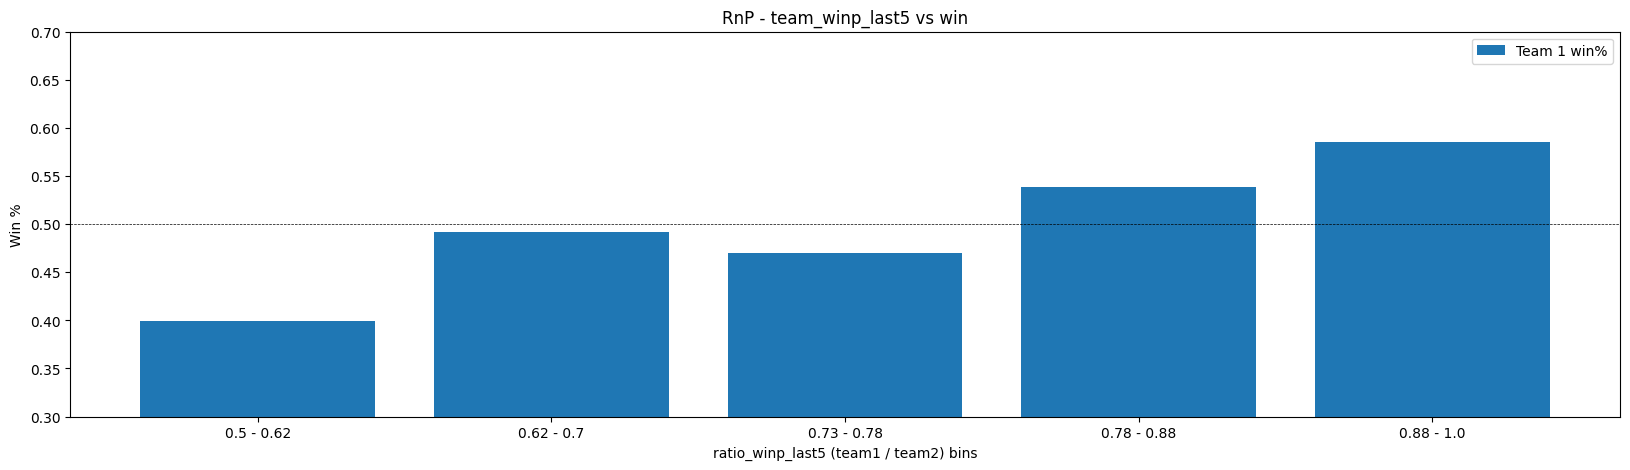

In [ ]:
train['team_winp_last5'] = 1/ (1+np.exp(-train['team_winp_last5']))
createRnP(train,'team_winp_last5')

slope: 0.6 / 0.39 =  1.53


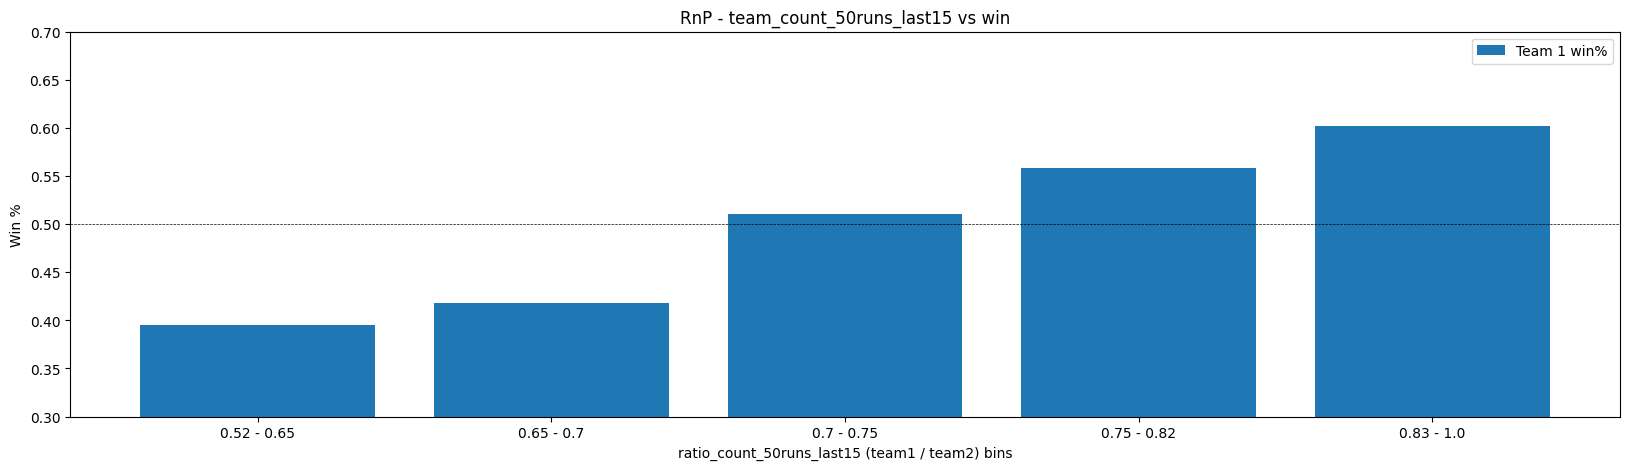

In [ ]:
train['team_count_50runs_last15'] = 1/ (1+np.exp(-train['team_count_50runs_last15']))
createRnP(train,'team_count_50runs_last15')

In [ ]:
train['team1_roster_ids'][0]

'9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0'

In [ ]:
def calculate_boundary_index(team,match_date,roster,alpha):
    matches_tmp = matches[(matches['team1_id'] == team) | (matches['team2_id'] == team)]
    matches_tmp = matches_tmp[matches_tmp['match_dt'] < match_date].sort_values(by="match_dt").tail(15)
    match_ids = matches_tmp['match id'].tolist()
    team_batsman_data , _ = RosterData(roster , match_ids)

    if not match_ids:
        return alpha

    boundaries = team_batsman_data["Fours"].sum()+team_batsman_data["Sixes"].sum()
    return (boundaries/len(match_ids)) + alpha

train['team1_BI'] = train.apply(lambda row: calculate_boundary_index(row['team1_id'], row['match_dt'] , row['team1_roster_ids'],1), axis=1)
train['team2_BI'] = train.apply(lambda row: calculate_boundary_index(row['team2_id'], row['match_dt'] , row['team2_roster_ids'],1), axis=1)

test['team1_BI'] = test.apply(lambda row: calculate_boundary_index(row['team1_id'], row['match_dt'] , row['team1_roster_ids'],1), axis=1)
test['team2_BI'] = test.apply(lambda row: calculate_boundary_index(row['team2_id'], row['match_dt'] , row['team2_roster_ids'],1), axis=1)

train['team1_BI'].fillna(0, inplace=True)
train['team2_BI'].fillna(0, inplace=True)
test['team2_BI'].fillna(0, inplace=True)
test['team1_BI'].fillna(0, inplace=True)

train["team_BI"]=1/(1+np.exp(-train["team1_BI"]/train['team2_BI']))
test["team_BI"]=1/(1+np.exp(-test["team1_BI"]/test['team2_BI']))

train.drop("team1_BI",inplace=True,axis=1)
train.drop('team2_BI',inplace=True,axis=1)
test.drop("team1_BI",inplace=True,axis=1)
test.drop('team2_BI',inplace=True,axis=1)

slope: 0.55 / 0.5 =  1.11


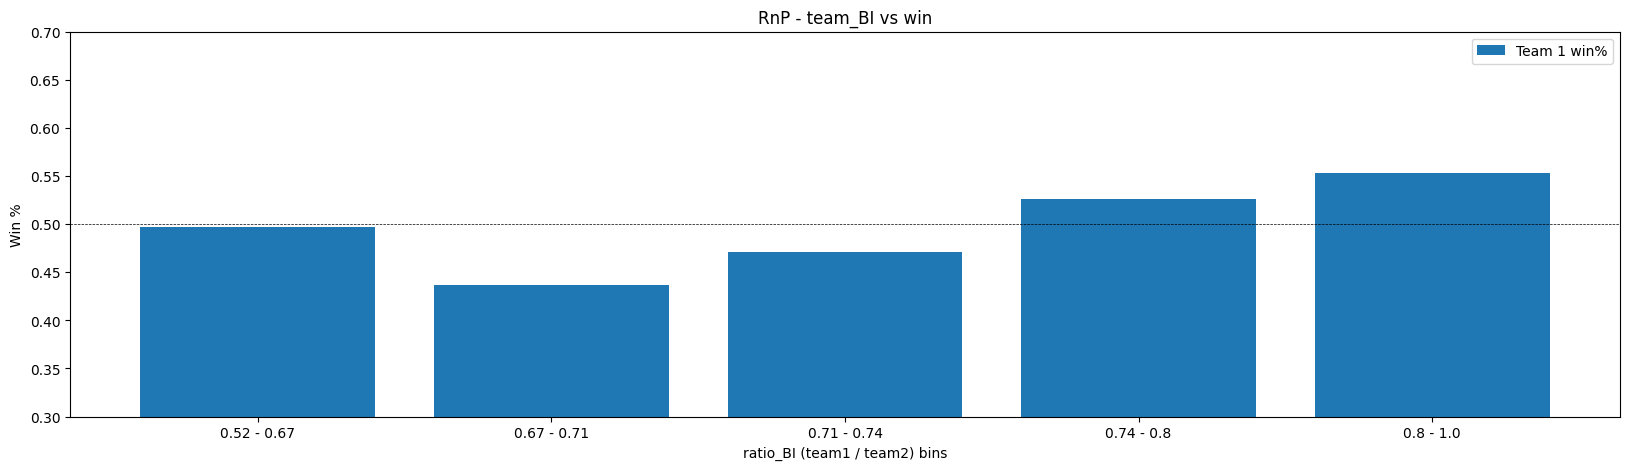

In [ ]:
createRnP(train , 'team_BI')

In [ ]:
def calculate_RBWI(team,match_date,alpha):
    matches_tmp = matches[(matches['team1_id'] == team) | (matches['team2_id'] == team)]
    matches_tmp = matches_tmp[matches_tmp['match_dt'] < match_date].sort_values(by="match_dt").tail(10)
    match_ids = matches['match id'].tolist()
    if not match_ids:
        return alpha
    team_batsman_data = batsman[(batsman['match id'].isin(match_ids)) & (batsman['team_id'] == team)]
    boundaries = (team_batsman_data["Fours"].sum())*4+(team_batsman_data["Sixes"].sum())*6
    runs = team_batsman_data["runs"].sum()
    return (runs-boundaries)/10 + alpha

train['team1_RBWI'] = train.apply(lambda row: calculate_RBWI(row['team1_id'], row['match_dt'],1), axis=1)
train['team2_RBWI'] = train.apply(lambda row: calculate_RBWI(row['team2_id'], row['match_dt'],1), axis=1)

test['team1_RBWI'] = test.apply(lambda row: calculate_RBWI(row['team1_id'], row['match_dt'],1), axis=1)
test['team2_RBWI'] = test.apply(lambda row: calculate_RBWI(row['team2_id'], row['match_dt'],1), axis=1)

train['team1_RBWI'].fillna(0, inplace=True)
train['team2_RBWI'].fillna(0, inplace=True)
test['team2_RBWI'].fillna(0, inplace=True)
test['team1_RBWI'].fillna(0, inplace=True)

train["team_RBWI"]=1/(1+np.exp(-train["team1_RBWI"]/train['team2_RBWI']))
test["team_RBWI"]=1/(1+np.exp(-test["team1_RBWI"]/test['team2_RBWI']))

train.drop("team1_RBWI",inplace=True,axis=1)
train.drop('team2_RBWI',inplace=True,axis=1)
test.drop("team1_RBWI",inplace=True,axis=1)
test.drop('team2_RBWI',inplace=True,axis=1)

slope: 0.63 / 0.34 =  1.85


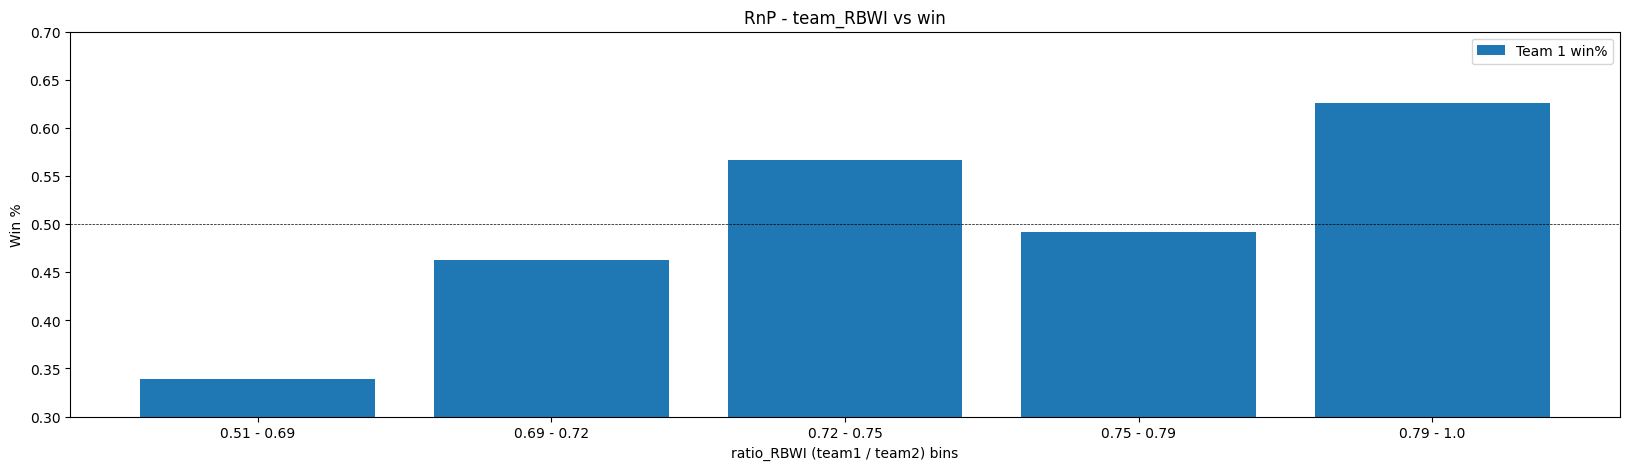

In [ ]:
createRnP(train,'team_RBWI')

In [ ]:
def avgEconomyOfATeam(teamid ,date, n):
  data = matches[(matches['match_dt'] < date) &\
                 ((matches['team1_id']==teamid) | (matches['team2_id']==teamid))]\
                        .sort_values(by='match_dt', ascending=False).head(n)

  if data.empty:
      return np.nan

  total_bowler_economy = bowler[(bowler['match id'].isin(data['match id'].tolist())) & (bowler['team_id'] == teamid)]['economy'].mean()

  return total_bowler_economy

train['Economy of team1'] = train.progress_apply(lambda x: \
                                  avgEconomyOfATeam(x['team1_id'], x['match_dt'], 10), axis=1)

train['Economy of team2'] = train.progress_apply(lambda x: \
                                  avgEconomyOfATeam(x['team2_id'], x['match_dt'], 10), axis=1)
test['Economy of team1'] = test.progress_apply(lambda x: \
                                  avgEconomyOfATeam(x['team1_id'], x['match_dt'], 10), axis=1)

test['Economy of team2'] = test.progress_apply(lambda x: \
                                  avgEconomyOfATeam(x['team2_id'], x['match_dt'], 10), axis=1)

train['Economy of team1'].fillna(train['Economy of team1'].mean(), inplace=True)
train['Economy of team2'].fillna(train['Economy of team2'].mean(), inplace=True)
test['Economy of team1'].fillna(test['Economy of team1'].mean(), inplace=True)
test['Economy of team2'].fillna(test['Economy of team2'].mean(), inplace=True)

train['Economy Rate Index'] = 1/(1+np.exp(-train['Economy of team1'] / train['Economy of team2']))
test['Economy Rate Index'] = 1/(1+np.exp(-test['Economy of team1'] / test['Economy of team2']))

test.drop(columns=['Economy of team1','Economy of team2'],inplace=True)
train.drop(columns=['Economy of team1','Economy of team2'],inplace=True)

100%|██████████| 207/207 [00:00<00:00, 371.74it/s]


slope: 0.48 / 0.44 =  1.09


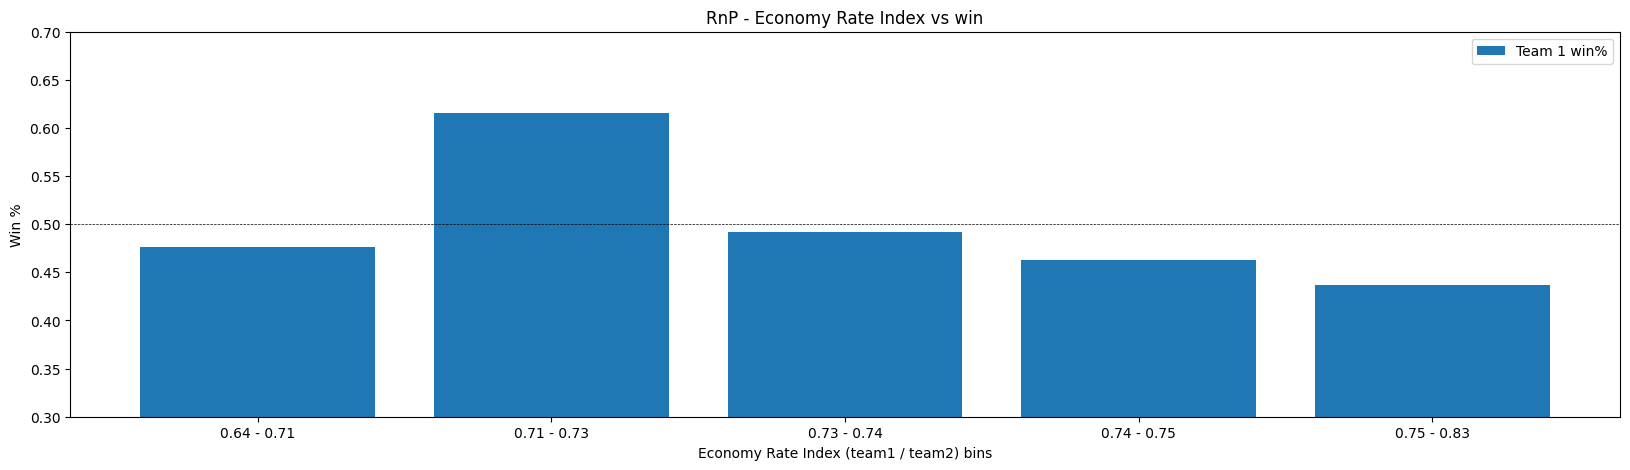

In [ ]:
createRnP(train,'Economy Rate Index')

In [ ]:
def BigWicketIndex(team_id, match_date, n=10):
  matchesData = matches[(matches['match_dt'] < match_date) & ((matches['team1_id'] == team_id) | (matches['team2_id']==team_id))]\
                                    .sort_values(by='match_dt').tail(n)
  if matchesData.empty:
    return 1

  numberOftimesBigWicket = len(matchesData[(matchesData['inning1_bat_id'] == team_id) & (matchesData['inning2_wickets'] >= 5)]) +\
                                  len(matchesData[(matchesData['inning1_bat_id'] != team_id) & (matchesData['inning1_wickets'] >= 5)])

  return (numberOftimesBigWicket / len(matchesData))+1

train['team1_big_wicket'] = train.progress_apply(lambda x: \
                                  BigWicketIndex(x['team1_id'], x['match_dt'], 10), axis=1)

train['team2_big_wicket'] = train.progress_apply(lambda x: \
                                  BigWicketIndex(x['team2_id'], x['match_dt'], 10), axis=1)
test['team1_big_wicket'] = test.progress_apply(lambda x: \
                                  BigWicketIndex(x['team1_id'], x['match_dt'], 10), axis=1)

test['team2_big_wicket'] = test.progress_apply(lambda x: \
                                  BigWicketIndex(x['team2_id'], x['match_dt'], 10), axis=1)

train['team1_big_wicket'].fillna(0 , inplace = True)
train['team2_big_wicket'].fillna(0 , inplace = True)
test['team1_big_wicket'].fillna(0 , inplace = True)
test['team2_big_wicket'].fillna(0 , inplace = True)

train['Big Wicket Index'] = 1/(1+np.exp(-train['team1_big_wicket'] / train['team2_big_wicket']))
test['Big Wicket Index'] = 1/(1+np.exp(-test['team1_big_wicket'] / test['team2_big_wicket']))

train.drop(columns=['team1_big_wicket','team2_big_wicket'],inplace=True)
test.drop(columns=['team1_big_wicket','team2_big_wicket'],inplace=True)

100%|██████████| 207/207 [00:00<00:00, 302.30it/s]


slope: 0.51 / 0.44 =  1.17


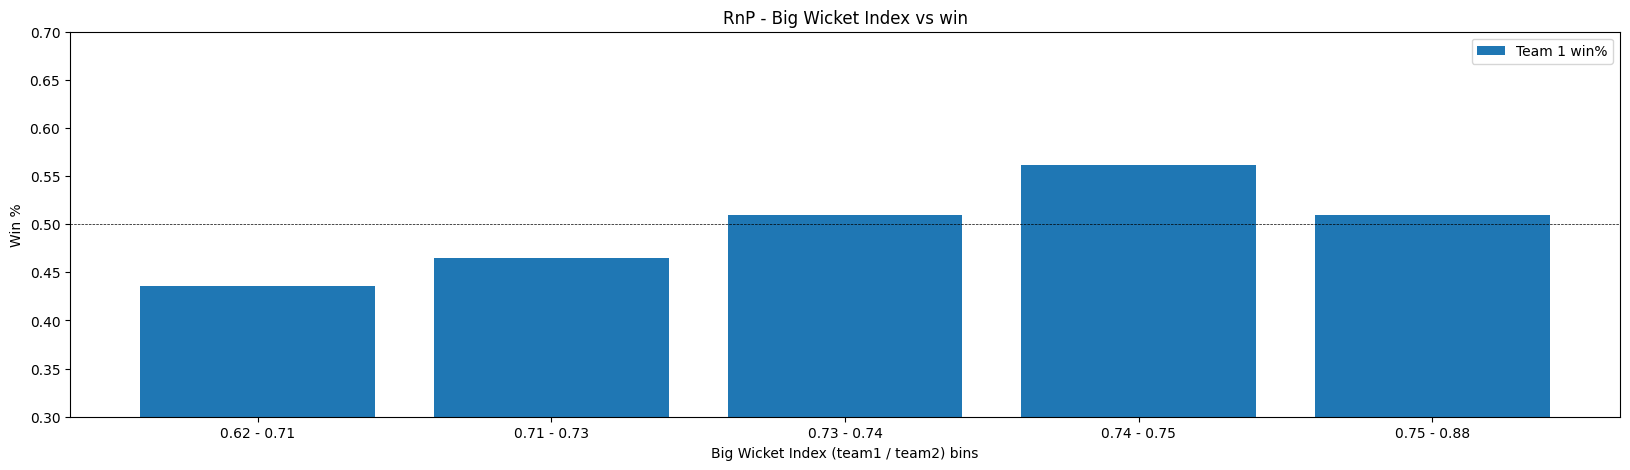

In [ ]:
createRnP(train,'Big Wicket Index')

In [ ]:
# ##### LAST 5 MATCHES NOT 10
# ##### LAST 5 MATCHES NOT 10
# ##### LAST 5 MATCHES NOT 10
# ##### LAST 5 MATCHES NOT 10
# ##### LAST 5 MATCHES NOT 10
# ##### LAST 5 MATCHES NOT 10
# ##### LAST 5 MATCHES NOT 10

def Bowled(team_id, match_date, n=10):
  matchesData = matches[(matches['match_dt'] < match_date) & ((matches['team1_id'] == team_id) | (matches['team2_id']==team_id))]\
                                    .sort_values(by='match_dt').tail(n)
  if matchesData.empty:
    return 1

  balls = matchesData[matchesData['inning1_bat_id']==team_id]['inning2_balls'].sum() + matchesData[matchesData['inning1_bat_id']!=team_id]['inning1_balls'].sum()

  return (balls / len(matchesData)) + 1


train['team1_bowled'] = train.progress_apply(lambda x: \
                                  Bowled(x['team1_id'], x['match_dt'], 5), axis=1)

train['team2_bowled'] = train.progress_apply(lambda x: \
                                  Bowled(x['team2_id'], x['match_dt'], 5), axis=1)

test['team1_bowled'] = test.progress_apply(lambda x: \
                                  Bowled(x['team1_id'], x['match_dt'], 5), axis=1)

test['team2_bowled'] = test.progress_apply(lambda x: \
                                  Bowled(x['team2_id'], x['match_dt'], 5), axis=1)

train['team1_bowled'].fillna(0 , inplace = True)
train['team2_bowled'].fillna(0 , inplace = True)
test['team1_bowled'].fillna(0 , inplace = True)
test['team2_bowled'].fillna(0 , inplace = True)

train['Balls Bowled Index'] = 1/(1 + np.exp(-train['team1_bowled']/ train['team2_bowled']))
test['Balls Bowled Index'] = 1/(1 + np.exp(-test['team1_bowled']/ test['team2_bowled']))

train.drop(columns=['team1_bowled','team2_bowled'],inplace=True)
test.drop(columns=['team1_bowled','team2_bowled'],inplace=True)

100%|██████████| 207/207 [00:00<00:00, 271.96it/s]


slope: 0.47 / 0.45 =  1.04


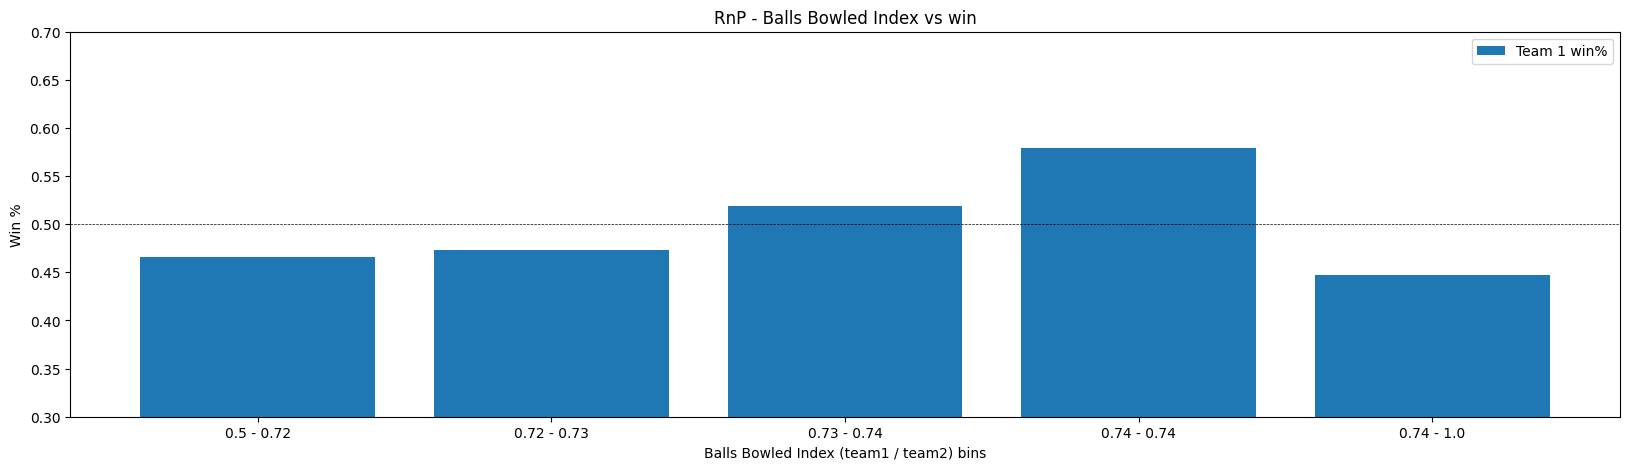

In [ ]:
createRnP(train,'Balls Bowled Index')

In [ ]:
def RunsPerWicket(team_id, match_date,roster, n=10):
  matchesData = matches[(matches['match_dt'] < match_date) & ((matches['team1_id'] == team_id) | (matches['team2_id']==team_id))]\
                                    .sort_values(by='match_dt').tail(n)
  if matchesData.empty:
    return 1

  _ , bowlerData = RosterData(roster , matchesData['match id'].tolist())
  bowlerData['wicket_count'].replace(0,1,inplace=True)

  runsPerWicket = (bowlerData['runs'].sum() / bowlerData['wicket_count'].sum()).sum()
  return (runsPerWicket / len(matchesData))

train['team1_runs_per_wicket'] = train.progress_apply(lambda x: \
                                   RunsPerWicket(x['team1_id'], x['match_dt'],x['team1_roster_ids'], 10), axis=1)

train['team2_runs_per_wicket'] = train.progress_apply(lambda x: \
                                 RunsPerWicket(x['team2_id'], x['match_dt'],x['team2_roster_ids'], 10), axis=1)

test['team1_runs_per_wicket'] = test.progress_apply(lambda x: \
                                   RunsPerWicket(x['team1_id'], x['match_dt'],x['team1_roster_ids'], 10), axis=1)

test['team2_runs_per_wicket'] = test.progress_apply(lambda x: \
                                 RunsPerWicket(x['team2_id'], x['match_dt'],x['team2_roster_ids'], 10), axis=1)

train['team1_runs_per_wicket'].fillna(0 , inplace = True)
train['team2_runs_per_wicket'].fillna(0 , inplace = True)
test['team1_runs_per_wicket'].fillna(0 , inplace = True)
test['team2_runs_per_wicket'].fillna(0 , inplace = True)

train['Run concede per Wicket Index'] = 1/(1+np.exp(-train['team1_runs_per_wicket'] / train['team2_runs_per_wicket']))
test['Run concede per Wicket Index'] = 1/(1+np.exp(-test['team1_runs_per_wicket'] / test['team2_runs_per_wicket']))

train.drop(columns=['team1_runs_per_wicket','team2_runs_per_wicket'],inplace=True)
test.drop(columns=['team1_runs_per_wicket','team2_runs_per_wicket'],inplace=True)

 14%|█▎        | 130/948 [00:01<00:11, 68.68it/s]<ipython-input-50-c1b7d28f684f>:10: RuntimeWarning: invalid value encountered in scalar divide
  runsPerWicket = (bowlerData['runs'].sum() / bowlerData['wicket_count'].sum()).sum()
 18%|█▊        | 167/948 [00:01<00:06, 114.50it/s]<ipython-input-50-c1b7d28f684f>:10: RuntimeWarning: invalid value encountered in scalar divide
  runsPerWicket = (bowlerData['runs'].sum() / bowlerData['wicket_count'].sum()).sum()
100%|██████████| 207/207 [00:01<00:00, 108.92it/s]


slope: 0.49 / 0.49 =  1.01


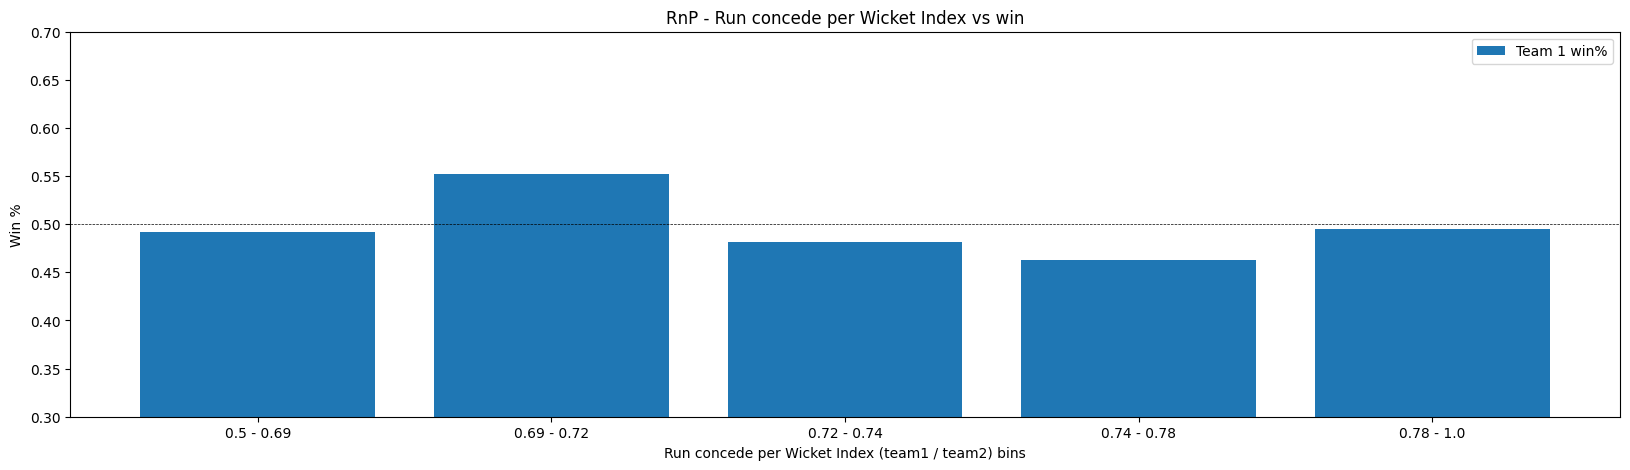

In [ ]:
createRnP(train,'Run concede per Wicket Index')

In [ ]:
matches['ing_1_bowl_strike_rate'] = matches['inning1_balls'] / np.where(matches['inning1_wickets']==0 , 1 , matches['inning1_wickets'])
matches['ing_2_bowl_strike_rate'] = matches['inning2_balls'] / np.where(matches['inning2_wickets']==0 , 1 , matches['inning2_wickets'])

def BowlingStrikeRate(team_id, match_date, n=10):
  matchesData = matches[(matches['match_dt'] < match_date) & ((matches['team1_id'] == team_id) | (matches['team2_id']==team_id))]\
                                    .sort_values(by='match_dt').tail(n)
  if matchesData.empty:
    return 1

  strikeRateSum = matchesData[matchesData['inning1_bat_id'] == team_id]['ing_2_bowl_strike_rate'].sum() +\
                  matchesData[matchesData['inning1_bat_id'] != team_id]['ing_1_bowl_strike_rate'].sum()

  return strikeRateSum / len(matchesData)

train['Bowl_strikerate_team1'] = train.progress_apply(lambda x: \
                                  BowlingStrikeRate(x['team1_id'], x['match_dt'], 5), axis=1)

train['Bowl_strikerate_team2'] = train.progress_apply(lambda x: \
                                  BowlingStrikeRate(x['team2_id'], x['match_dt'], 5), axis=1)

test['Bowl_strikerate_team1'] = test.progress_apply(lambda x: \
                                  BowlingStrikeRate(x['team1_id'], x['match_dt'], 5), axis=1)

test['Bowl_strikerate_team2'] = test.progress_apply(lambda x: \
                                  BowlingStrikeRate(x['team2_id'], x['match_dt'], 5), axis=1)

train['Bowl_strikerate_team1'].fillna(0 , inplace = True)
train['Bowl_strikerate_team2'].fillna(0 , inplace = True)

test['Bowl_strikerate_team1'].fillna(0 , inplace = True)
test['Bowl_strikerate_team2'].fillna(0 , inplace = True)

train['Bowler Strike Rate Index'] = 1/(1+np.exp(-train['Bowl_strikerate_team1'] / train['Bowl_strikerate_team2']))
test['Bowler Strike Rate Index'] = 1/(1+np.exp(-test['Bowl_strikerate_team1'] / test['Bowl_strikerate_team2']))

train.drop(columns=['Bowl_strikerate_team1','Bowl_strikerate_team2'],inplace=True)
test.drop(columns=['Bowl_strikerate_team1','Bowl_strikerate_team2'],inplace=True)
matches.drop(columns=['ing_1_bowl_strike_rate','ing_2_bowl_strike_rate'],inplace=True)

100%|██████████| 207/207 [00:00<00:00, 322.25it/s]


slope: 0.58 / 0.48 =  1.2


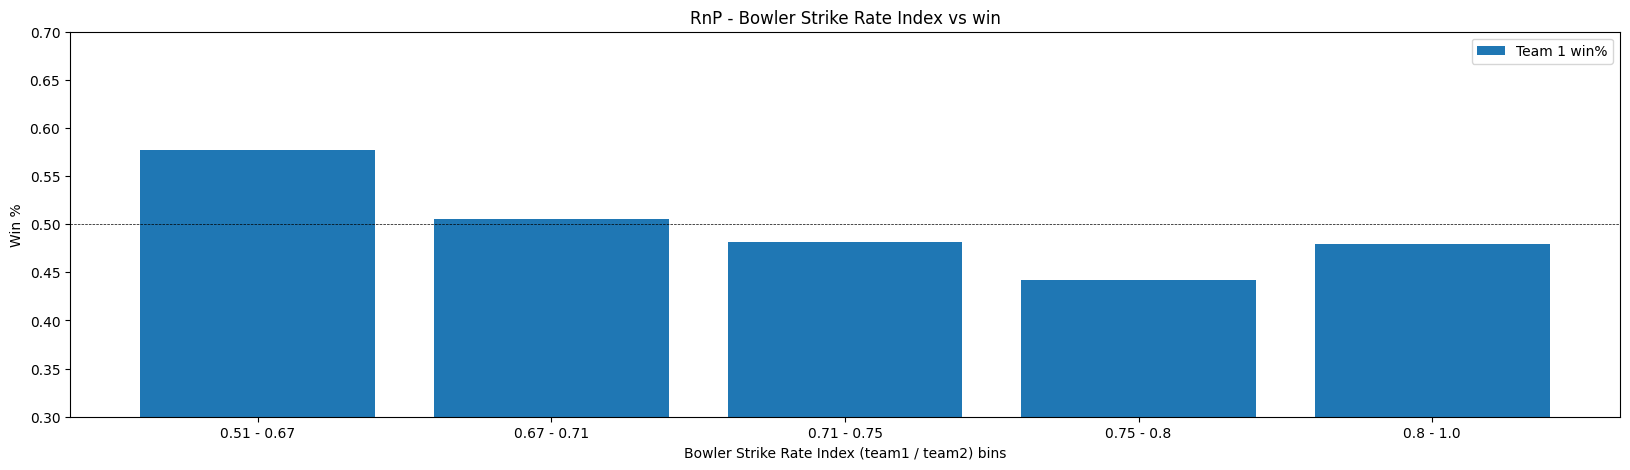

In [ ]:
createRnP(train,'Bowler Strike Rate Index')

Run After this for model evaluation

In [ ]:
target = 'winner_01'
features = train.columns.difference(['Unnamed: 0', 'match id', 'winner', 'winner_id',
                                     "ground_id","city","series_name","team1","team2",
                                     "team1_id","team2_id","team1_roster_ids","team2_roster_ids","toss decision",
                                    "toss winner","venue","match_dt","season","lighting",'toss_decision_01',
                                     'toss_winner_01', 'team1only_avg_runs_last15','lighting_day match', 'lighting_day/night match',
                                     'lighting_night match',"Balls Bowled Index" , 'winner_01'])
X = train[features]
y = train[target]


In [ ]:
test_X= test[features]

In [ ]:
features

Index(['Big Inning Index', 'Big Wicket Index', 'Bowler Strike Rate Index',
       'Economy Rate Index', 'Finishing Index', 'Run concede per Wicket Index',
       'Strike Rate Index', 'season_enc', 'team_BI', 'team_RBWI',
       'team_count_50runs_last15', 'team_winp_last5'],
      dtype='object')

In [ ]:
X[X["team_BI"]==np.inf].count()

Big Inning Index                0
Big Wicket Index                0
Bowler Strike Rate Index        0
Economy Rate Index              0
Finishing Index                 0
Run concede per Wicket Index    0
Strike Rate Index               0
season_enc                      0
team_BI                         0
team_RBWI                       0
team_count_50runs_last15        0
team_winp_last5                 0
dtype: int64

In [ ]:
X = X.fillna(X.mean())

In [ ]:
X.to_csv("data.csv")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
def calc_vif(df):

  X = df.copy()
  X = add_constant(X)  # Add constant term to avoid singular matrix errors
  vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
  return vif

calc_vif(X.copy())

const                           2923.609546
Big Inning Index                1.831150   
Big Wicket Index                2.014294   
Bowler Strike Rate Index        1.836664   
Economy Rate Index              1.586170   
Finishing Index                 2.132813   
Run concede per Wicket Index    1.650830   
Strike Rate Index               3.726659   
season_enc                      1.008466   
team_BI                         1.808604   
team_RBWI                       1.594367   
team_count_50runs_last15        1.785482   
team_winp_last5                 2.121081   
dtype: float64

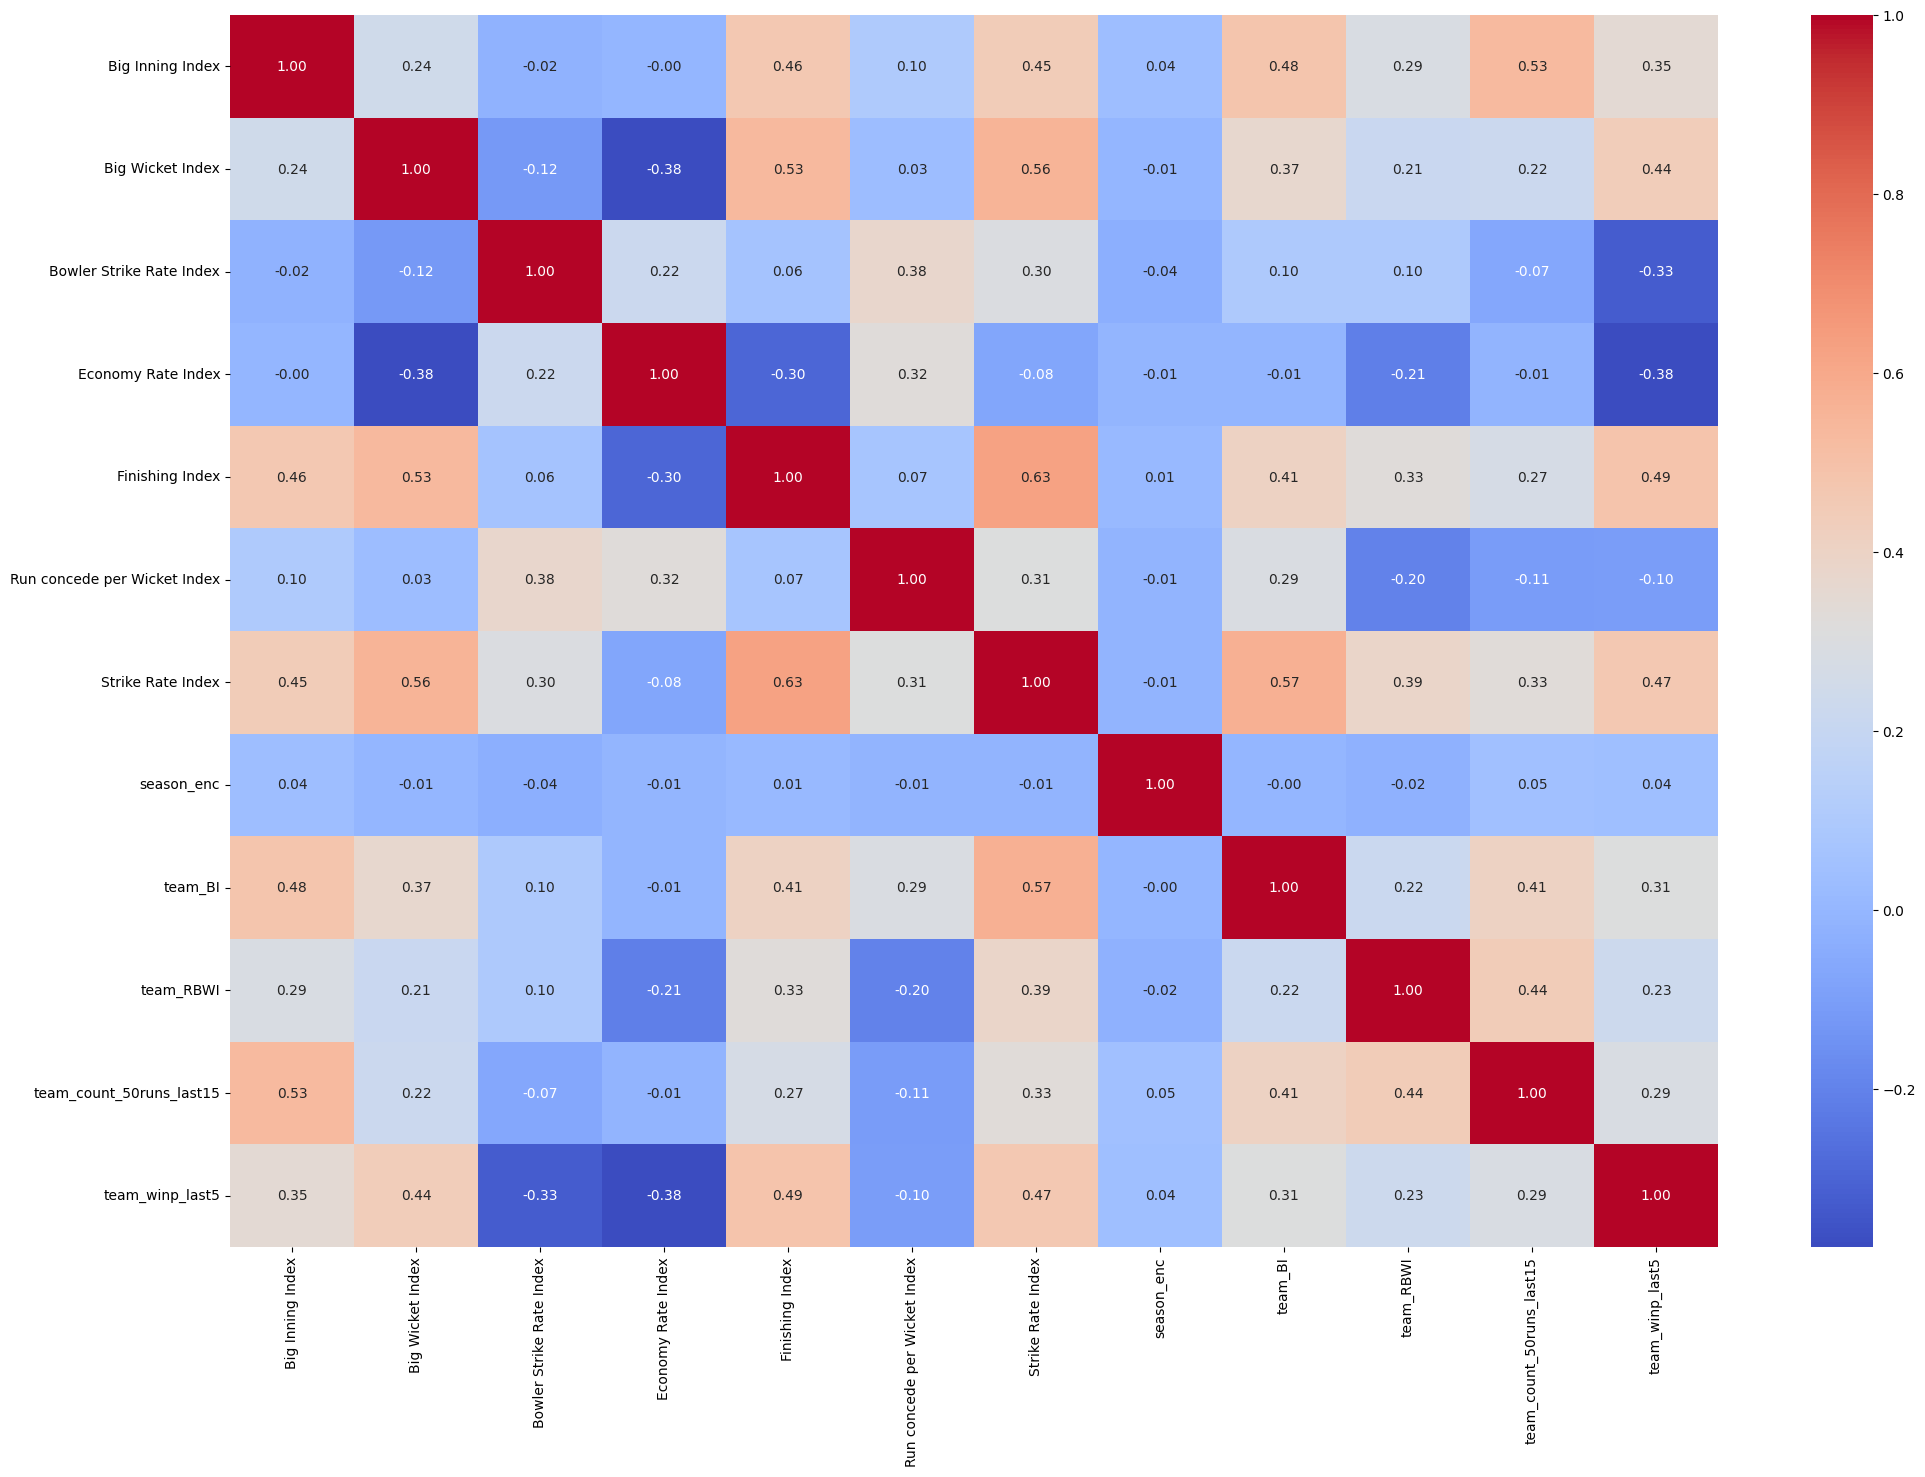

In [ ]:
corr_matrix = X.corr()

plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)


In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Define a function for evaluating the XGBoost model
def xgb_evaluate(n_estimators, max_depth, learning_rate, subsample, colsample_bytree,gamma,alpha,reg_lambda):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                              learning_rate=learning_rate,
                              subsample=subsample, colsample_bytree=colsample_bytree,objective="binary:logistic",
                              random_state=421,gamma=gamma,booster="dart",alpha=alpha,reg_lambda=reg_lambda,
                              )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    return model.score(X_test, y_test)

# Define the parameter bounds
param_bounds = {
    'n_estimators': (30, 150),
    'max_depth': (3,10),
    'learning_rate': (0.001, 0.3),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.5, 1),
    "gamma":(0,0.5),
    "alpha":(0,10),
    "reg_lambda":(0,10),

}

# Perform Bayesian Optimization
bayes_opt = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=421)
bayes_opt.maximize(init_points=1, n_iter=3)

# Extract the best parameters and convert them to appropriate types
best_params = bayes_opt.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

|   iter    |  target   |   alpha   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6875    | 6.828     | 0.9017    | 0.02814   | 0.2966    | 4.418     | 43.33     | 3.33      | 0.9485    |
| 2         | 0.7708    | 4.738     | 0.5493    | 0.1031    | 0.1919    | 6.661     | 92.05     | 7.6       | 0.8403    |
| 3         | 0.7708    | 4.123     | 0.6745    | 0.3299    | 0.05951   | 5.67      | 92.28     | 8.072     | 0.8668    |
| 4         | 0.75      | 10.0      | 0.5       | 0.0       | 0.3       | 10.0      | 135.0     | 2.937     | 0.8       |


In [ ]:
features

Index(['Big Inning Index', 'Big Wicket Index', 'Bowler Strike Rate Index',
       'Economy Rate Index', 'Finishing Index', 'Run concede per Wicket Index',
       'Strike Rate Index', 'season_enc', 'team_BI', 'team_RBWI',
       'team_count_50runs_last15', 'team_winp_last5'],
      dtype='object')

In [ ]:
best_params

{'alpha': 4.738343405327613,
 'colsample_bytree': 0.5492974117063218,
 'gamma': 0.10314623330045586,
 'learning_rate': 0.19189281829120797,
 'max_depth': 6,
 'n_estimators': 92,
 'reg_lambda': 7.600072562549842,
 'subsample': 0.8402649786117076}

Cross-Validation Score: 53.77777777777777
Cross-Validation Train Score: [62.73749309 71.20245706 78.69252349 83.41255853 86.52486781 87.07847084
 87.97542941 89.55736092 89.68932181 88.97751172]
Cross-Validation Test Score: [56.32915622 56.43052075 55.48036759 56.11807296 56.22110833 57.16847675
 56.96129212 56.64550265 58.22612086 58.43776107]


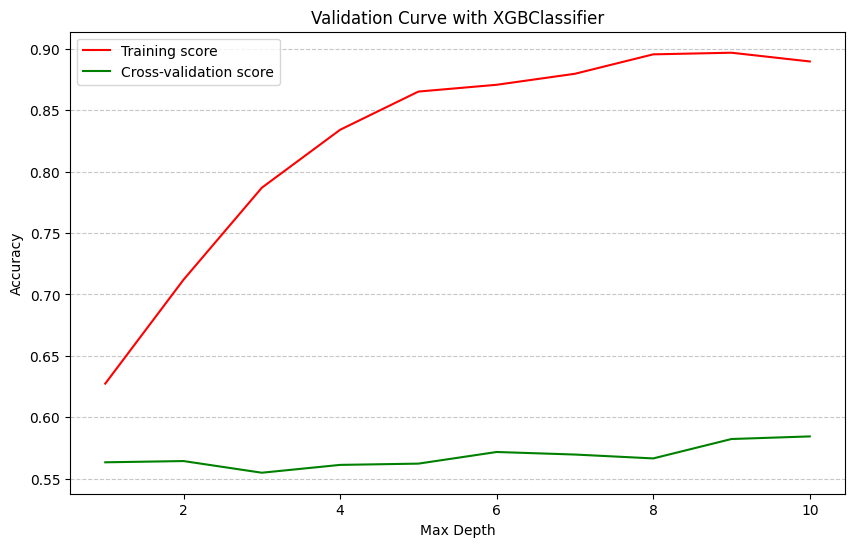

In [ ]:
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import StratifiedKFold

model.set_params(**best_params,booster="dart",objective="binary:logistic")
# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
mean_score = scores.mean()
print("Cross-Validation Score:", mean_score * 100)

# Validation Curve
param_range = np.arange(1, 11)
train_scores, test_scores = validation_curve(
    model, X_scaled, y, param_name="max_depth", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
print("Cross-Validation Train Score:", train_scores_mean * 100)
print("Cross-Validation Test Score:", test_scores_mean * 100)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.title("Validation Curve with XGBClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [ ]:
scores

array([0.56666667, 0.57777778, 0.47777778, 0.54444444, 0.52222222])

In [ ]:
model.set_params(**best_params,booster="dart",objective="binary:logistic")

XGBClassifier(alpha=4.738343405327613, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5492974117063218, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.10314623330045586,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.19189281829120797,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=92, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.7708333333333334
Precision: 0.7983796296296296
Recall: 0.7708333333333334
F1 Score: 0.7673138803568818
Confusion Matrix:
[[16  9]
 [ 2 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.70      0.91      0.79        23

    accuracy                           0.77        48
   macro avg       0.79      0.78      0.77        48
weighted avg       0.80      0.77      0.77        48



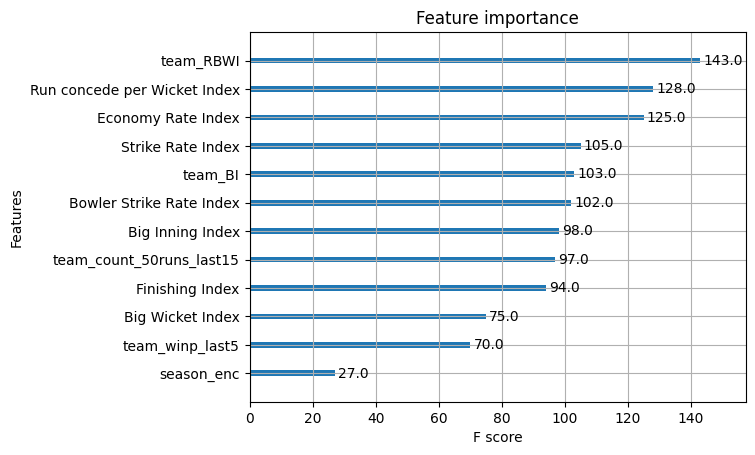

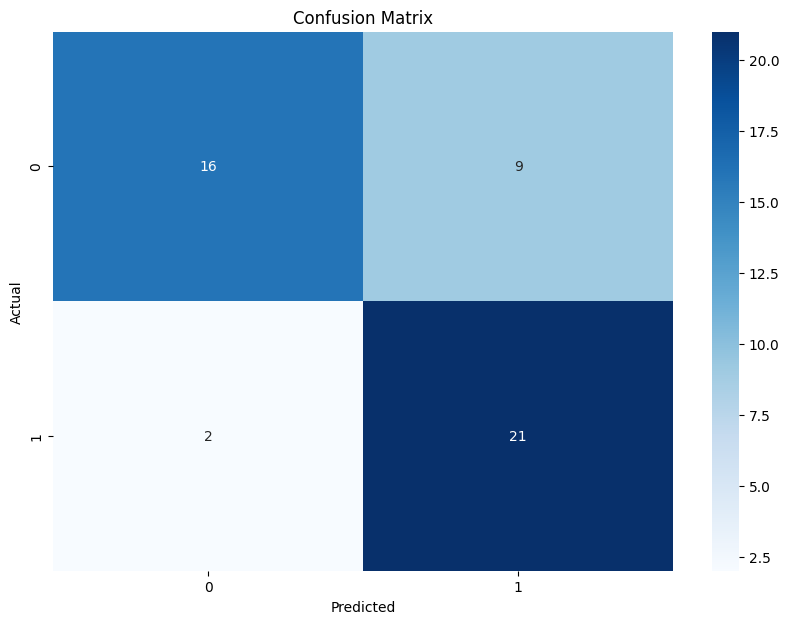

In [ ]:
# Train final model with best parameters
model = xgb.XGBClassifier(**best_params,random_state=421,objective="binary:logistic",booster="dart")
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance
xgb.plot_importance(model)
plt.show()

# Additional: Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.8777777777777778
Precision: 0.8778172839506173
Recall: 0.8777777777777778
F1 Score: 0.8777801920915859
Confusion Matrix:
[[393  53]
 [ 57 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       446
           1       0.88      0.87      0.88       454

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



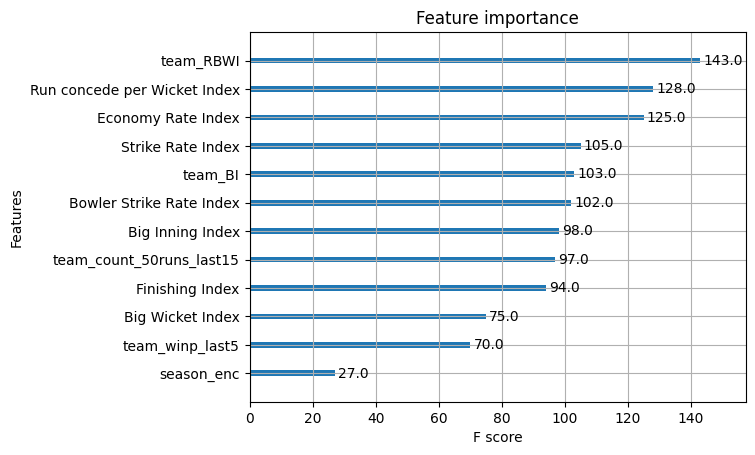

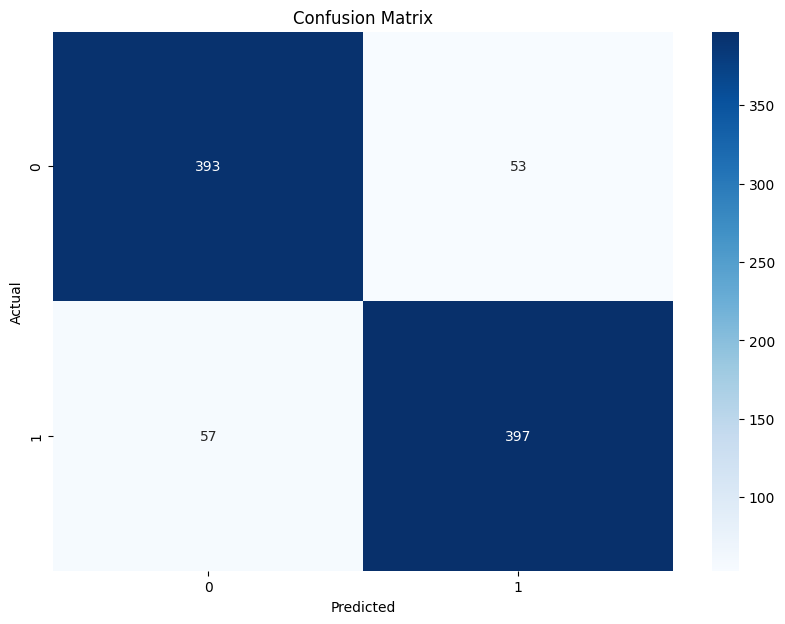

In [ ]:
# Train final model with best parameters
model = xgb.XGBClassifier(**best_params,random_state=421,objective="binary:logistic",booster="dart")
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))
print("Classification Report:")
print(classification_report(y_train, y_pred))

# Plot feature importance
xgb.plot_importance(model)
plt.show()

# Additional: Visualize confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_train

,Big Inning Index,Big Wicket Index,Bowler Strike Rate Index,Economy Rate Index,Finishing Index,Run concede per Wicket Index,Strike Rate Index,season_enc,team_BI,team_RBWI,team_count_50runs_last15,team_winp_last5
307,0.947368,0.742466,0.642431,0.722635,0.656347,0.694972,0.718475,1,0.748153,0.747721,0.753552,0.625321
268,0.772727,0.731059,0.884448,0.735067,0.731059,0.797282,0.704067,2,0.750740,0.728261,0.641834,0.625321
119,1.176471,0.742466,0.670489,0.719124,0.726462,0.695330,0.745092,1,0.723122,0.740957,0.768525,0.921537
159,0.941176,0.721115,0.807139,0.752693,0.762542,0.716278,0.703244,1,0.709267,0.729322,0.760213,0.564454
463,1.277778,0.731059,0.635403,0.737908,0.780611,0.786369,0.765474,1,0.667395,0.769027,0.647289,0.878212
...,...,...,...,...,...,...,...,...,...,...,...,...
767,0.900000,0.741840,0.706764,0.722296,0.738553,0.692616,0.738517,2,0.936871,0.691398,0.669491,0.875706
72,1.066667,0.707310,0.761412,0.751157,0.697059,0.759011,0.689622,0,0.765432,0.745521,0.687718,0.551794
908,1.142857,0.731059,0.636620,0.714003,0.736070,0.717243,0.766068,3,0.749803,0.747397,0.731059,0.875706
235,0.707143,0.721115,0.743832,0.673682,0.770998,0.687350,0.727312,4,0.668703,0.820150,0.660756,0.979309


In [ ]:
train['y_pred_01'] = model.predict(X)
train['win_pred_score'] = model.predict_proba(X)[:,1]

In [ ]:
train['y_pred_01'] = model.predict(X)
train['win_pred_score'] = model.predict_proba(X)[:,1]
test['y_pred_01'] = model.predict(test_X)
test['win_pred_score'] = model.predict_proba(test_X)[:,1]

In [ ]:
train

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,winner_01,toss_winner_01,toss_decision_01,season_enc,lighting_day match,lighting_day/night match,lighting_night match,Strike Rate Index,Big Inning Index,Finishing Index,team_BI,team_RBWI,Economy Rate Index,Big Wicket Index,Balls Bowled Index,Run concede per Wicket Index,Bowler Strike Rate Index,y_pred_01,win_pred_score
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,0.841131,0.661980,139.000000,1,1,0,2,0,1,0,0.701776,0.928571,0.783421,0.680388,0.834681,0.727163,0.719997,0.733358,0.714301,0.729710,0,0.416771
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,0.783421,0.875706,156.000000,0,1,0,0,0,1,0,0.732289,1.062500,0.763277,0.709536,0.750182,0.705269,0.768525,0.726777,0.695563,0.817456,1,0.507823
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.702063,0.661980,173.266667,0,1,0,3,0,1,0,0.706046,0.888889,0.691017,0.692282,0.792356,0.742041,0.709867,0.725788,0.733696,0.787058,1,0.549819
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,0.897216,0.878212,164.266667,0,0,1,3,1,0,0,0.760028,1.133333,0.731059,0.721165,0.722425,0.709295,0.731059,0.716212,0.700851,0.667364,0,0.297780
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.693850,0.790488,164.666667,1,1,0,3,0,0,1,0.742236,0.900000,0.647042,0.646056,0.749993,0.744876,0.709867,0.727850,0.759108,0.653476,1,0.658389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.694985,0.731059,147.333333,0,1,0,1,0,0,1,0.710434,0.800000,0.689974,0.643448,0.684342,0.720247,0.731059,0.695995,0.693846,0.768653,0,0.447884
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd Tn,Taunton,2023-06-02,day/night match,Vy Bt,2023,1042,

In [ ]:
test

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,season_enc,lighting_day match,lighting_day/night match,lighting_night match,Strike Rate Index,Big Inning Index,Finishing Index,team_BI,team_RBWI,Economy Rate Index,Big Wicket Index,Balls Bowled Index,Run concede per Wicket Index,Bowler Strike Rate Index,y_pred_01,win_pred_score
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,1,0,2,0,0,1,0.702475,0.900000,0.747808,0.670941,0.711388,0.679668,0.731059,0.735599,0.667676,0.694562,1,0.832688
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,1,0,2,0,1,0,0.673527,0.701754,0.726126,0.667389,0.587598,0.705935,0.711520,0.719375,0.724997,0.950018,1,0.689554
2,9433654,Gn,7573,5164844.0:8110185.0:2979857.0:1722048.0:2707431.0:3834361.0:2336487.0:5161652.0:3212292.0:8339701.0:5192830.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:4817000.0:5288226.0:8211328.0:3252395.0:2850868.0:74367.0:9344117.0,St,field,Sa Gs Cf,Cardiff,2023-06-21,day/night match,Vy Bt,2023,4521,0.666667,0.344262,178.800000,0.0,155.733333,1,0,3,0,1,0,0.718983,1.066667,0.735052,0.675038,0.666075,0.775818,0.731059,0.728781,0.832657,0.838003,1,0.742907
3,9097248,Ks,22784,3496933.0:4167673.0:4160316.0:1863889.0:310883.0:2667244.0:2294837.0:4239794.0:3802378.0:4168086.0:4817014.0,Ds,22763,3399745.0:4898074.0:3782225.0:2252452.0:2231907.0:3490087.0:7497013.0:4888260.0:3062079.0:6639674.0:3747484.0,Ks,bat,St Gs Pk Pt Eh,Port Elizabeth,2022-02-08,day match,CA T0 Ce,2021/22,1224,0.500000,0.259259,138.000000,0.0,142.500000,0,1,0,1,0,0,0.724308,0.840000,0.616029,0.764621,0.694725,0.756688,0.689974,0.723253,0.791608,0.771530,0,0.425800
4,9097234,Ws,23841,4166882.0:3009215.0:1963443.0:3252927.0:4171859.0:3009334.0:6665462.0:4875086.0:2295642.0:6845950.0:6816718.0,Ts,23750,2654014.0:2667223.0:3406717.0:3057312.0:4159644.0:4888218.0:2259739.0:4160267.0:328607.0:2659222.0:2654028.0,Ts,field,St Gs Pk Pt Eh,Port Elizabeth,2022-02-07,day match,CA T0 Ce,2021/22,1224,0.166667,1.000000,155.800000,100.0,NaN,1,0,0,1,0,0,0.751618,1.000000,0.684111,0.845887,0.684375,0.734389,0.708661,0.739102,0.680012,0.853671,1,0.633601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,9984162,Pb Ks,30407,7881719.0:8127181.0:2231928.0:2642751.0:5053082.0:7923859.0:9660804.0:2035102.0:8180500.0:2733380.0:7453697.0:7881845.0,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:3057312.0:8117990.0:8228408.0:7925546.0:3429236.0:2282125.0:8072056.0:5618038.0,Pb Ks,bat,Rv Gi Il Sm Ul Hd,Hyderabad,2024-05-19,day/night match,In Pr Le,2024,13880,0.307692,1.952381,181.400000,50.0,181.625000,0,1,5,0,1,0,0.728536,0.684211,0.735827,0.621138,0.700885,0.708727,0.731059,0.735482,0.665775,0.638830,1,0.584700
203,9984176,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:8117990.0:3057312.0:8228408.0:7925546.0:3429236.0:2282125.0:8072056.0:5618038.0,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:5061748.0:1934099.0:7556303.0:2181157.0:8465057.0:9188528.0:7758638.0,Ss Hd,bat,Na Mi Sm Ad,Ahmedabad,2024-05-21,night match,I

In [ ]:
train['win_pred_score'] = np.where( (train['y_pred_01']==0), (1-train['win_pred_score']), train['win_pred_score'])
test['win_pred_score'] = np.where( (test['y_pred_01']==0), (1-test['win_pred_score']), test['win_pred_score'])

In [ ]:
train['win_pred_team_id'] = np.where( (train['winner_01']==0), (train['team1_id']), train['team2_id'])
test['win_pred_team_id'] = np.where( (test['y_pred_01']==0), (test['team1_id']), test['team2_id'])

In [ ]:
df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':model.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                        .reset_index(drop=True).head(10)
df_feat_importance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   feat_name             10 non-null     object 
 1   model_feat_imp_train  10 non-null     float32
dtypes: float32(1), object(1)
memory usage: 248.0+ bytes


In [ ]:
train

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,winner_01,toss_winner_01,toss_decision_01,season_enc,lighting_day match,lighting_day/night match,lighting_night match,Strike Rate Index,Big Inning Index,Finishing Index,team_BI,team_RBWI,Economy Rate Index,Big Wicket Index,Balls Bowled Index,Run concede per Wicket Index,Bowler Strike Rate Index,y_pred_01,win_pred_score,win_pred_team_id
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,0.841131,0.661980,139.000000,1,1,0,2,0,1,0,0.701776,0.928571,0.783421,0.680388,0.834681,0.727163,0.719997,0.733358,0.714301,0.729710,0,0.583229,12634
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,0.783421,0.875706,156.000000,0,1,0,0,0,1,0,0.732289,1.062500,0.763277,0.709536,0.750182,0.705269,0.768525,0.726777,0.695563,0.817456,1,0.507823,20
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.702063,0.661980,173.266667,0,1,0,3,0,1,0,0.706046,0.888889,0.691017,0.692282,0.792356,0.742041,0.709867,0.725788,0.733696,0.787058,1,0.549819,10576
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,0.897216,0.878212,164.266667,0,0,1,3,1,0,0,0.760028,1.133333,0.731059,0.721165,0.722425,0.709295,0.731059,0.716212,0.700851,0.667364,0,0.702220,36084
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.693850,0.790488,164.666667,1,1,0,3,0,0,1,0.742236,0.900000,0.647042,0.646056,0.749993,0.744876,0.709867,0.727850,0.759108,0.653476,1,0.658389,48341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044.0:5053082.0:2035102.0:3851518.0:7453697.0:7881845.0:3068547.0,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000.0:1642738.0:196580.0:2294823.0:360086.0:7879829.0:7968225.0,Pb Ks,30407,Ci Sr Ks,field,We Sm Mi,Mumbai,2022-04-25,night match,In Pr Le,2022,5004,0.694985,0.731059,147.333333,0,1,0,1,0,0,1,0.710434,0.800000,0.689974,0.643448,0.684342,0.720247,0.731059,0.695995,0.693846,0.768653,0,0.552116,30407
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:7672874.0:4005406.0:7671166.0:4489708.0:8820538.0:2593758.0:3590362.0,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:6320362.0:2535420.0:5288226.0:3252395.0:334963.0:2850868.0:55299.0,St,9701,St,field,Te Cr As Cy Gd 

In [ ]:
df_feat_importance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   feat_name             10 non-null     object 
 1   model_feat_imp_train  10 non-null     float32
dtypes: float32(1), object(1)
memory usage: 248.0+ bytes


In [ ]:
train_data=train.copy()
test_data=test.copy()

In [ ]:
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r2'

In [ ]:
algo_name = "xgboost"
is_ensemble = 'no'
n_trees = best_params['n_estimators']
depth = best_params["max_depth"]
lr = best_params["learning_rate"]

In [ ]:
## refactor

df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'])], \
                     train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'])]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

In [ ]:
df_file1.shape

(1155, 19)

In [ ]:

df_file1.head()

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9272619,r2,33928,0.832688,0.711388,0.666667,0.679668,0.694562,0.670941,0.667676,0.900000,1.000000,2,0.702475,xgboost,no,92,6,0.191893
1,9086958,r2,69,0.689554,0.587598,0.142857,0.705935,0.950018,0.667389,0.724997,0.701754,0.207921,2,0.673527,xgboost,no,92,6,0.191893
2,9433654,r2,9701,0.742907,0.666075,0.666667,0.775818,0.838003,0.675038,0.832657,1.066667,0.344262,3,0.718983,xgboost,no,92,6,0.191893
3,9097248,r2,22784,0.574200,0.694725,0.500000,0.756688,0.771530,0.764621,0.791608,0.840000,0.259259,0,0.724308,xgboost,no,92,6,0.191893
4,9097234,r2,23750,0.633601,0.684375,0.166667,0.734389,0.853671,0.845887,0.680012,1.000000,1.000000,0,0.751618,xgboost,no,92,6,0.191893


In [ ]:
df_feat_importance

,feat_name,model_feat_imp_train
0,team_RBWI,0.102399
1,team_count_50runs_last15,0.093987
2,Economy Rate Index,0.090522
3,Bowler Strike Rate Index,0.088536
4,team_BI,0.083847
5,Run concede per Wicket Index,0.083436
6,Big Inning Index,0.081284
7,team_winp_last5,0.081192
8,season_enc,0.080049
9,Strike Rate Index,0.079361


In [ ]:
feature_desc = {
    'team_count_50runs_last15': 'Ratio of the number of 50s scored by players in team1 to the number of 50s scored by players in team2 in the last 15 games',
    'team_winp_last5': 'Ratio of team1\'s win percentage to team2\'s win percentage in the last 5 games',
    'Economy Rate Index': 'Index representing the economy rate of bowlers, calculated as runs conceded per over',
    'Big Inning Index': 'Team1\'s win percentage against Team2 in the last 15 games',
    'team_BI': 'Team1\'s average inning runs in the last 15 games',
    'team_RBWI': 'Numerical form of the season. Takes 1 for the oldest season and increases for the latest seasons',
    'Strike Rate Index': 'Index representing the batting strike rate, calculated as runs scored per 100 balls faced',
    'Bowler Strike Rate Index': 'Index representing the bowler\'s strike rate, calculated as the number of balls bowled per wicket taken',
    'Big Wicket Index': 'Index representing the significance of wickets taken, especially those of key players',
    'Run concede per Wicket Index': 'Index representing the average number of runs conceded per wicket taken',
}


In [ ]:
# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

In [ ]:
df_file2

,feat_name,model_feat_imp_train,feat_rank_train,feat_description
feat_id,,,,
1,team_RBWI,0.102399,1,Numerical form of the season. Takes 1 for the oldest season and increases for the latest seasons
2,team_count_50runs_last15,0.093987,2,Ratio of the number of 50s scored by players in team1 to the number of 50s scored by players in team2 in the last 15 games
3,Economy Rate Index,0.090522,3,"Index representing the economy rate of bowlers, calculated as runs conceded per over"
4,Bowler Strike Rate Index,0.088536,4,"Index representing the bowler's strike rate, calculated as the number of balls bowled per wicket taken"
5,team_BI,0.083847,5,Team1's average inning runs in the last 15 games
6,Run concede per Wicket Index,0.083436,6,Index representing the average number of runs conceded per wicket taken
7,Big Inning Index,0.081284,7,Team1's win percentage against Team2 in the last 15 games
8,team_winp_last5,0.081192,8,Ratio of team1's win percentage to team2's win percentage in the last 5 games
9,season_enc,0.080049,9,NaN


In [ ]:
df_file1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1155 entries, 0 to 947
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match id          1155 non-null   int64  
 1   dataset_type      1155 non-null   object 
 2   win_pred_team_id  1155 non-null   int64  
 3   win_pred_score    1155 non-null   float32
 4   indep_feat_id1    1155 non-null   float64
 5   indep_feat_id2    1155 non-null   float64
 6   indep_feat_id3    1155 non-null   float64
 7   indep_feat_id4    1155 non-null   float64
 8   indep_feat_id5    1155 non-null   float64
 9   indep_feat_id6    1155 non-null   float64
 10  indep_feat_id7    1155 non-null   float64
 11  indep_feat_id8    1155 non-null   float64
 12  indep_feat_id9    1155 non-null   int64  
 13  indep_feat_id10   1155 non-null   float64
 14  train_algorithm   1155 non-null   object 
 15  is_ensemble       1155 non-null   object 
 16  train_hps_trees   1155 non-null   int64  
 17  t

In [ ]:
df_file1[df_file1['dataset_type']=='r1']['dataset_type'] = 'r2'
df_file1 = df_file1[df_file1['dataset_type']=='r2']

In [ ]:
df_file1

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9272619,r2,33928,0.832688,0.711388,0.666667,0.679668,0.694562,0.670941,0.667676,0.900000,1.000000,2,0.702475,xgboost,no,92,6,0.191893
1,9086958,r2,69,0.689554,0.587598,0.142857,0.705935,0.950018,0.667389,0.724997,0.701754,0.207921,2,0.673527,xgboost,no,92,6,0.191893
2,9433654,r2,9701,0.742907,0.666075,0.666667,0.775818,0.838003,0.675038,0.832657,1.066667,0.344262,3,0.718983,xgboost,no,92,6,0.191893
3,9097248,r2,22784,0.574200,0.694725,0.500000,0.756688,0.771530,0.764621,0.791608,0.840000,0.259259,0,0.724308,xgboost,no,92,6,0.191893
4,9097234,r2,23750,0.633601,0.684375,0.166667,0.734389,0.853671,0.845887,0.680012,1.000000,1.000000,0,0.751618,xgboost,no,92,6,0.191893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,9984162,r2,36014,0.584700,0.700885,0.307692,0.708727,0.638830,0.621138,0.665775,0.684211,1.952381,5,0.728536,xgboost,no,92,6,0.191893
203,9984176,r2,36014,0.625546,0.715121,0.857143,0.738708,0.768302,0.698386,0.823721,0.904762,0.344262,5,0.746197,xgboost,no,92,6,0.191893
204,9984183,r2,30428,0.666374,0.782671,1.368421,0.732488,0.760953,0.799244,0.679324,1.142857,0.672131,5,0.727607,xgboost,no,92,6,0.191893
205,9984190,r2,30428,0.727603,0.759113,0.736842,0.765827,0.876358,0.726725,0.766393,0.904762,0.344262,5,0.719566,xgboost,no,92,6,0.191893


In [ ]:
df_file1.to_csv('Round_Submission.csv', index=False)
df_file2.to_csv('Feature_description.csv')

In [ ]:
template = pd.read_csv('submission_template_file1.csv')
round_submission = pd.read_csv('Round_Submission.csv')

In [ ]:
[f for f in template.columns if f not in round_submission.columns]

[]

In [ ]:
[f for f in round_submission.columns if f not in template.columns]

[]

In [ ]:
print('ALL SET! JAI SHREE KRISHNA')

ALL SET! JAI SHREE KRISHNA
